In [1]:
import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

2024-05-02 16:47:01.944877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Estilos y reproducibilidad

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

font_leg = {'family' : 'DejaVu Sans',
            'weight' : 'bold',
            'size'   : 10}

# para reproducibilidad
def seeds(seed):
    # python
    import random
    random.seed(seed)

    # numpy
    np.random.seed(seed)

    # tensorflow
    tf.random.set_seed(seed)
    
#seeds(0)
# ó:
#tf.keras.utils.set_random_seed(0)

## <center><h2>Elementos de una red neuronal</h2></center>

Ya se ha visto la estructura básica de una red neuronal. Vimos que una neurona realiza una suma ponderada y sobre esta aplica una función de activación que será el valor de salida de la neurona, luego, una vez se han obtenido las predicciones de la red para los datos de entrenamiento, se puede calcular la función de costo que será el objetivo a minimizar por medio del ajuste de los pesos en cada época del entrenamiento. Este ajuste se realiza por medio de algún algoritmo de minimización y, en esencia, todos hacen uso del gradiente de la función de costo. Para calcular este gradiente se debe utilizar un algoritmo muy especial conocido como *El Algoritmo de Backpropagation*. En este notebook se analizarán en mayor detalle cada una de estas componentes del proceso de entrenamiento de la red neuronal. 

## Funciones de activación

Una neurona tendrá un determinado número de entradas $x_i$, cada una de ellas un escalar, e internamente realizará una suma ponderada $z=\sum w_ix_i+b$ de estas, luego la suma es entregada a una función de activación $a(z)$ y este será el valor de salida de la neurona. 

Por ejemplo, en el caso del perceptrón propuesto por [Frank Rosenblatt](https://es.wikipedia.org/wiki/Perceptr%C3%B3n), la función de activación es la función escalón unitario, pero tenemos gran variedad de funciones de activación, por ejemplo, keras nos ofrece las siguientes:

<p><center>relu, sigmoid, softmax, softplus, softsign, tanh, selu, elu, exponential, leaky_relu, relu6, silu, hard_silu, gelu, hard_sigmoid, linear, mish, log_softmax.</center></p>

aunque también nos permite definir las nuestras propias. El objetivo de una función de activación es lograr activar las neuronas de modo que la red completa logre aprender. No tener una función de activación en una red, por más grande que sea, hará que toda la red se comporte como si tuviésemos una sola capa. Consideremos la primera capa con función de activación $a^{[1]}(z)$, denotemos por $z^{[1]}$ las sumas ponderadas para cada neurona de la primera capa: 

\begin{equation}
z^{[1]} = w^{[1]}x^{[1]}+b^{[1]} \nonumber
\end{equation}

con $x^{[1]}$ la entrada a la capa $1$. Para la segunda capa sus entradas serían las salidas de la primera capa, es decir $a^{[1]}(z^{[1]})$. No tener función de activación es lo mismo que usar $a(z)=z$, así, para la segunda capa tendríamos que su salida sería:

\begin{eqnarray}
a^{[2]}(z^{[2]}) &=& z^{[2]}\\
                 &=& w^{[2]}x^{[2]}+b^{[2]}\nonumber \\
                 &=& w^{[2]}a^{[1]}+b^{[2]}\nonumber  \\
                 &=& w^{[2]}z^{[1]}+b^{[2]}\nonumber  \\
                 &=& w^{[2]}[w^{[1]}x^{[1]}+b^{[1]}]+b^{[2]}\nonumber \\
                 &=& w^{[2]}w^{[1]}x^{[1]} + w^{[2]}b^{[1]} +b^{[2]}\nonumber  \\ 
\end{eqnarray}

definiendo $w^{[2]}w^{[1]}=w'$ y $w^{[2]}b^{[1]} +b^{[2]}=b'$ obtenemos

\begin{equation}
a^{[2]}(z^{[2]}) = w'x^{[1]}+b' \nonumber 
\end{equation}

De esta expresión concluimos que la ausencia de una función de activación acabará por hacer que toda la red colapse a una sola capa lineal por lo que no se produce aprendizaje durante el entrenamiento sin importar cuantas capas se utilicen. 

A continuación vamos a comenzar por analizar algunas de las funciones de activación más relevantes y su derivada pues esta es también de alta importancia para poder entender su uso. 

### Lineal
La función de activación más simple sería la función de activación lineal que es una función identidad que, como acabamos de ver, no permite que se produzca aprendizaje en las capas internas de la red.

Veamos su representación gráfica y la de su derivada. Pero antes, como estaremos graficando varias funciones de activación minimicemos código generando una función que haga esto.

In [3]:
def plot_af(x,
            af,
            daf,
            af_ylabel,
            daf_ylabel, **kwards):
    
    # gráfico
    fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

    ax[0].plot(x, af(x, **kwards), color="k", lw=2)
    ax[0].set_title("AF", **font)
    ax[0].set_ylabel(af_ylabel, **font)
    ax[0].set_xlim(min(x), max(x))

    ax[1].plot(x, daf(x), color="red", lw=2)
    ax[1].set_title("Derivative of the AF", **font)
    ax[1].set_ylabel(daf_ylabel, **font)
    ax[1].set_xlim(min(x), max(x))

    plt.tight_layout()
    
    

def plot_accuracy_loss(history, name):
    
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(history["accuracy"],     color="red",   ls="-",  lw=2, label=list(history.keys())[0])
    ax.plot(history["val_accuracy"], color="red",   ls="--", lw=2, label=list(history.keys())[2])
    ax.plot(history["loss"],         color="black", ls="-",  lw=2, label=list(history.keys())[1])
    ax.plot(history["val_loss"],     color="black", ls="--", lw=2, label=list(history.keys())[3])

    ax.set_xlim(0, len(history["accuracy"])-1)
    ax.set_xlabel("Ephocs", **font)
    ax.set_ylabel("Score", **font)
    ax.set_title(name, **font)

    ax.legend(prop=font, ncol=2, frameon=False)
    plt.show()

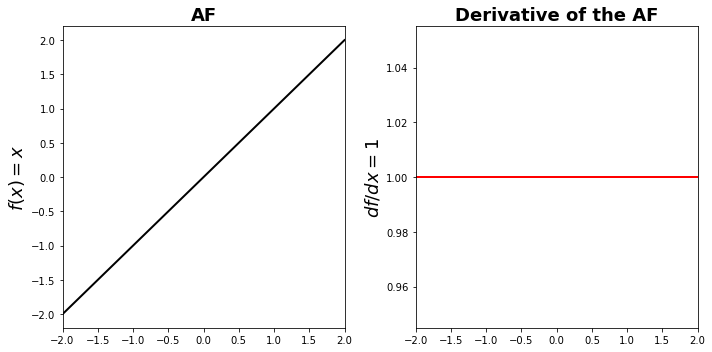

In [4]:
# derivada
x = np.linspace(-2, 2, 100)

def d_lineal(x):
    return 1
d_lineal = np.vectorize(d_lineal)

plot_af(x,
        af=keras.activations.linear,
        daf=d_lineal,
        af_ylabel=f"$f(x)=x$",
        daf_ylabel=f"$df/dx=1$")


Aparte de lo que ya se ha dicho hasta este momento, hay una característica importante que se puede resaltar sobre la función identidad, y es que su derivada es constante, es decir siempre tiene el mismo valor, $1$. Este hecho permite que se pueda producir una actualización constante de los pesos pues, como se verá cuando analicemos el algoritmo de backpropagation, una de las condiciones que tienen que cumplir las funciones de activación es que su derivada no puede ser nula en todos los puntos de su dominio. La derivada de la función de activación es determinante a la hora de entrenar un modelo pues determinará la rapidez con la cual este aprende. 

Esta función de activación es usada principalmente en la última capa de redes para problemas de regresión. 

In [5]:
# Algunos datos de prueba
np.random.seed(0)
xp = np.random.uniform(-10, 10, 10)
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [6]:
keras.activations.linear(xp)

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

Generemos ahora un modelo con múltiples capas para probar el aprendizaje de una red neuronal. 

In [7]:
def create_model(name,
                 shape,
                 layers=4,
                 units=[80, 90, 80, 80],
                 af="relu",
                 output_af="softmax"):
    
    # units per layer
    if type(units)==int:
        units=[units]*layers
        
    if len(units)!=layers:
        raise Exception(f"Length of units={len(units)} differs from number of layers={layers}")
        
    @tf.function
    def f(x): return x
    if type(af)==str or type(af)==type(lambda x:x) or type(af)==type(f):
        af=[af]*layers
     
    # layers of the model
    model = keras.Sequential(name=name)
    model.add(keras.Input(shape=shape))
    model.add(keras.layers.Flatten(name="Flatten"))
    
    for i in range(len(units)):
        model.add(keras.layers.Dense(units=units[i], activation=af[i], name=f"layer_{i+1}"))
        
    model.add(keras.layers.Dense(units=len(class_names), activation=output_af, name="output"))
    
    return model

#### Datos

In [8]:
# carga
fm = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fm.load_data()

# normalización
train_images, test_images = train_images/255., test_images/255.

# clases
class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
)

for i, label in enumerate(class_names):
    print(f"{i} --> {label}")
    
train_images.shape, test_images.shape

0 --> T-shirt/top
1 --> Trouser
2 --> Pullover
3 --> Dress
4 --> Coat
5 --> Sandal
6 --> Shirt
7 --> Sneaker
8 --> Bag
9 --> Ankle boot


((60000, 28, 28), (10000, 28, 28))

In [9]:
# modelo
model_fm_linear = create_model(name="fashionmn_af_linear", 
                               shape=train_images[0].shape,
                               af="linear",
                               output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_linear.compile(optimizer=opt,
                        loss=loss, metrics=["accuracy"])

model_fm_linear.summary()

2024-05-02 16:47:05.976584: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "fashionmn_af_linear"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_linear = model_fm_linear.fit(train_images,
                                        train_labels,
                                        validation_split=0.2,
                                        epochs=10)

history_fm_linear = history_fm_linear.history

# medimos el tiempo de ejecución
time_fm_linear = datetime.datetime.now() - start
print(f"\nTime to run using linear: {time_fm_linear}")

Epoch 1/10


2024-05-02 16:47:06.289857: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7598 - loss: 0.6782 - val_accuracy: 0.8375 - val_loss: 0.4736
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8293 - loss: 0.4917 - val_accuracy: 0.8415 - val_loss: 0.4535
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8363 - loss: 0.4675 - val_accuracy: 0.8422 - val_loss: 0.4583
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8372 - loss: 0.4645 - val_accuracy: 0.8311 - val_loss: 0.4981
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8427 - loss: 0.4493 - val_accuracy: 0.8301 - val_loss: 0.4926
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8474 - loss: 0.4388 - val_accuracy: 0.8312 - val_loss: 0.4840
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8514 - loss: 0.4294 - val_accuracy: 0.8447 - val_loss: 0.4347
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8496 - loss: 0.4295 - val_accura

Lo primero que podemos observar del uso de la función de activación lineal es que las métricas del modelo y su función de costo no mejoran en cada época, contrario a esto parecen oscilar al rededor de un valor promedio. Esto nos muestra de entrada que la elección de esta función de activación para todas las capas no es una buena elección, algo que irémos confirmando a medida que veamos la aplicación de otras funciones de activación. Se debe esperar que el valor de las métricas y la función de costo mejoren en cada época, este no es el caso.

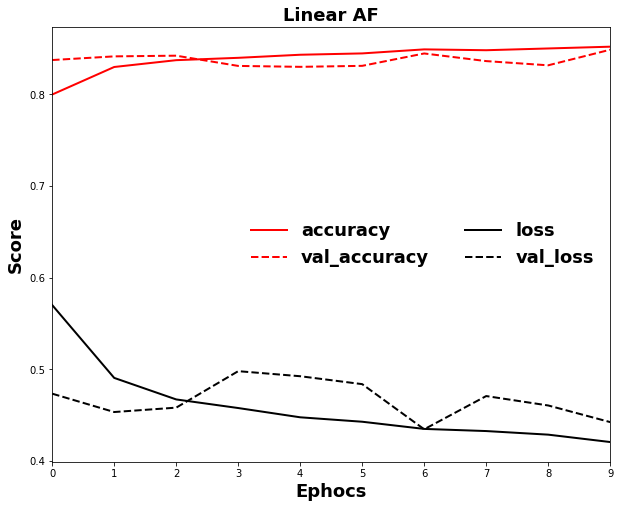

In [11]:
plot_accuracy_loss(history_fm_linear, name="Linear AF")

Como decíamos, las métricas y función de costo varían muy poco en cada iteración, este comportamiento se hará más evidente cuando veamos las otras funciones de activación.

Veamos ahora la capacidad de predicción de este modelo.

In [12]:
# Métricas de testeo
loss_acc_linear_test = model_fm_linear.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8341 - loss: 0.4629


In [13]:
# Métricas de entrenamiento
loss_acc_linear_train = model_fm_linear.evaluate(x=train_images, y=train_labels)

  38/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8612 - loss: 0.3882

2024-05-02 16:48:04.648633: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8573 - loss: 0.4075


### ReLU

[ReLU](https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)) es una de las funciones de activación más utilizadas para capas ocultas en la actualidad por sus excelentes características a la hora de entrenar. Está definida por

\begin{eqnarray}
    \text{ReLU}(x) = \text{max}(0,x)
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      0 & si & x < 0 \\
                                                      1 & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{equation}

graficamente tenemos

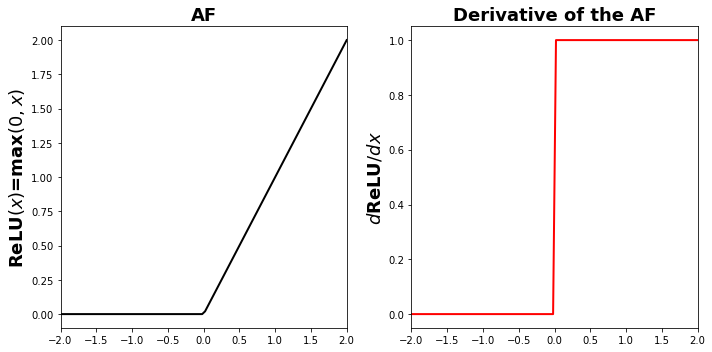

In [14]:
# derivada
x = np.linspace(-2, 2, 100)

def d_relu(x):
    if x<0:
        return 0
    return 1

d_relu = np.vectorize(d_relu)

plot_af(x,
        af=keras.activations.relu,
        daf=d_relu,
        af_ylabel=f"ReLU$(x)$=max$(0,x)$",
        daf_ylabel=f"$d$ReLU$/dx$")


Otras funciones de activación como *tanh* y *sofmax* tienen derivadas que en los extremos tienden a ser nulas y esto genera el conocido como *desvanecimiento del gradiente* que estudiaremos más adelante. La función ReLU, por otro lado, tiene una derivada constante para valores positivos, además de ser una función muy sencilla de calcular comparada con funciones como *tanh* y *sofmax*. Estas características hacen de ella una función de activación altamente utilizada ya que puede acelerar el proceso de aprendizaje de la red. Otro atributo relevante es que genera esparsidad en la red al apagar algunas neuronas (su derivada es cero para valores menores a cero) conduciendo así a una reducción indirecta del overfitting. 

Veamos su comportamiento con algunos datos:

In [15]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [16]:
keras.activations.relu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.97627008, 4.30378733, 2.05526752, 0.89766366, 0.        ,
       2.91788226, 0.        , 7.83546002, 9.27325521, 0.        ])>

Ahora entrenemos un modelo con la misma aquitectura que el modelo anterior pero utilizaremos una función de activación RelU en las capas ocultas. 

In [17]:
# modelo
model_fm_relu = create_model(name="fashionmn_af_relu", 
                               shape=train_images[0].shape, 
                               af="relu",
                               output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_relu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_relu.summary()

Model: "fashionmn_af_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_relu = model_fm_relu.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_relu = history_fm_relu.history
# medimos el tiempo de ejecución
time_fm_relu = datetime.datetime.now() - start
print(f"\nTime to run using relu: {time_fm_relu}")

Epoch 1/10


2024-05-02 16:48:08.964311: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7503 - loss: 0.7002 - val_accuracy: 0.8298 - val_loss: 0.4710
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8572 - loss: 0.3935 - val_accuracy: 0.8627 - val_loss: 0.3864
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8715 - loss: 0.3484 - val_accuracy: 0.8661 - val_loss: 0.3641
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8784 - loss: 0.3320 - val_accuracy: 0.8744 - val_loss: 0.3536
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8855 - loss: 0.3120 - val_accuracy: 0.8786 - val_loss: 0.3473
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8910 - loss: 0.2963 - val_accuracy: 0.8701 - val_loss: 0.3602
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8953 - loss: 0.2814 - val_accuracy: 0.8695 - val_loss: 0.3509
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8976 - loss: 0.2717 - val_accurac

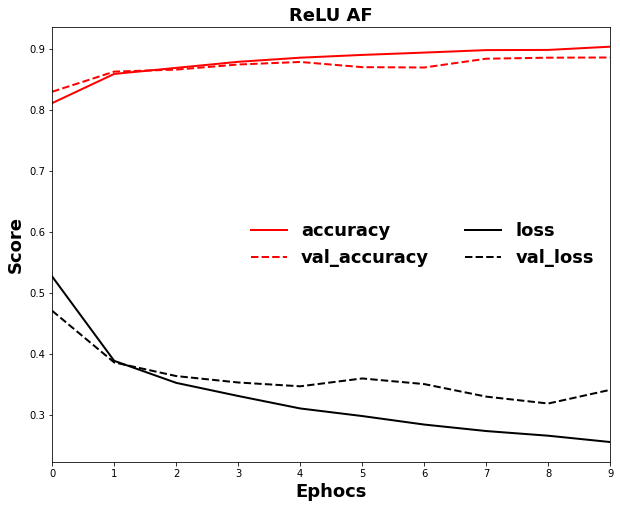

In [19]:
plot_accuracy_loss(history_fm_relu, name="ReLU AF")

En esta ocasión vemos que tanto las métricas como la función de perdida mejoran en cada iteración, contrario a cuando utilizamos la función de activación lineal. 

In [20]:
# Métricas de testeo
loss_acc_relu_test = model_fm_relu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8751 - loss: 0.3759


In [21]:
# Métricas de entrenamiento
loss_acc_relu_train = model_fm_relu.evaluate(x=train_images, y=train_labels)

  58/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9140 - loss: 0.2313

2024-05-02 16:49:00.452746: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9079 - loss: 0.2487


### sigmoide
La función de activación sigmoide o logística está definida por:

\begin{eqnarray}
    \text{sig}(x) = \frac{1}{1+e^{-x}}
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{sig}}{dx} = \text{sig}(x)[1-\text{sig}(x)]
\end{equation}

graficamente tenemos


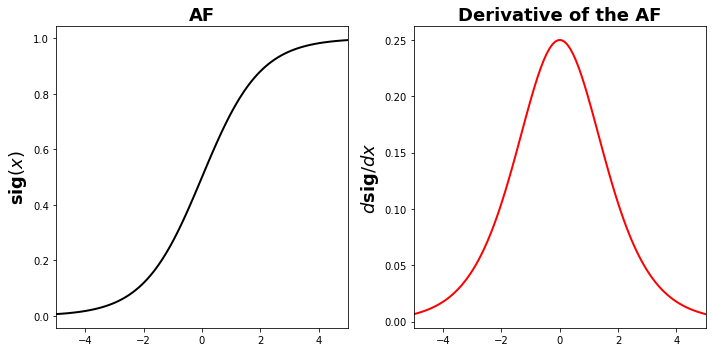

In [22]:
# derivada
x = np.linspace(-5, 5, 100)

def d_sig(x):
    return np.exp(-x)/(1+np.exp(-x))**2

d_sig = np.vectorize(d_sig)

plot_af(x,
        af=keras.activations.sigmoid,
        daf=d_sig,
        af_ylabel=f"sig$(x)$",
        daf_ylabel=f"$d$sig$/dx$")

La función sigmoide sólo puede retornar valores positivos pues está acotada entre $0$ y $1$, esto representa de entrada un problema pues puede restringir los pesos durante el entrenamiento retardando así la velocidad de entrenamiento de la red. Su derivada, diferente a la función de activación ReLU, nunca es nula, pero tiende a serlo para valores alejados de cero de la suma ponderada, por lo cual también sufre del problema del desvanecimiento del gradiente, además su derivada no es tan grande como por ejemplo si lo es la de la función tanh que veremos a continuación. 

La función sigmoide es clasicamente utilizada en la última capa de las redes neuronales cuando se tienen problemas de clasificación binaria. 

In [23]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [24]:
# con sigmoide de keras
keras.activations.sigmoid(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.72636749, 0.98666301, 0.88647879, 0.71046915, 0.17844712,
       0.94872337, 0.22300222, 0.9996047 , 0.99990611, 0.0885742 ])>

In [25]:
# con numpy
1/(1+np.exp(-xp))

array([0.72636749, 0.98666301, 0.88647879, 0.71046915, 0.17844712,
       0.94872337, 0.22300222, 0.9996047 , 0.99990611, 0.0885742 ])

Ahora entrenemos un modelo con una función de activación tanh en las capas ocultas. 

In [26]:
# modelo
model_fm_sig = create_model(name="fashionmn_af_sigm", 
                             shape=train_images[0].shape, 
                             af="sigmoid",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_sig.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_sig.summary()

Model: "fashionmn_af_sigm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_sig = model_fm_sig.fit(train_images,
                                  train_labels,
                                  validation_split=0.2,
                                  epochs=10)

history_fm_sig = history_fm_sig.history

# medimos el tiempo de ejecución
time_fm_sig = datetime.datetime.now() - start
print(f"\nTime to run using sigmoid: {time_fm_sig}")

Epoch 1/10


2024-05-02 16:49:05.247587: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4679 - loss: 1.3973 - val_accuracy: 0.7914 - val_loss: 0.5717
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8133 - loss: 0.5229 - val_accuracy: 0.8428 - val_loss: 0.4491
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8504 - loss: 0.4341 - val_accuracy: 0.8426 - val_loss: 0.4433
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8644 - loss: 0.3906 - val_accuracy: 0.8643 - val_loss: 0.3854
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8704 - loss: 0.3636 - val_accuracy: 0.8705 - val_loss: 0.3692
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8777 - loss: 0.3413 - val_accuracy: 0.8655 - val_loss: 0.3813
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8835 - loss: 0.3262 - val_accuracy: 0.8707 - val_loss: 0.3652
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8890 - loss: 0.3103 - val_accur

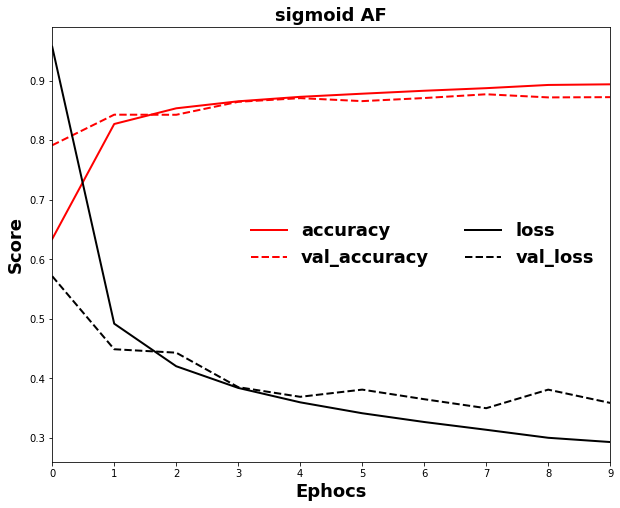

In [28]:
plot_accuracy_loss(history_fm_sig, name="sigmoid AF")

In [29]:
# Métricas de testeo
loss_acc_sig_test = model_fm_sig.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8598 - loss: 0.3897


In [30]:
# Métricas de entrenamiento
loss_acc_sig_train = model_fm_sig.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8936 - loss: 0.2908


### tanh

La función tangente hiperbólica está definida a partir del uso de funciones exponenciales:

\begin{eqnarray}
    \text{tanh}(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{tanh}}{dx} = 1- \text{tanh}^2(x)
\end{equation}

graficamente tenemos

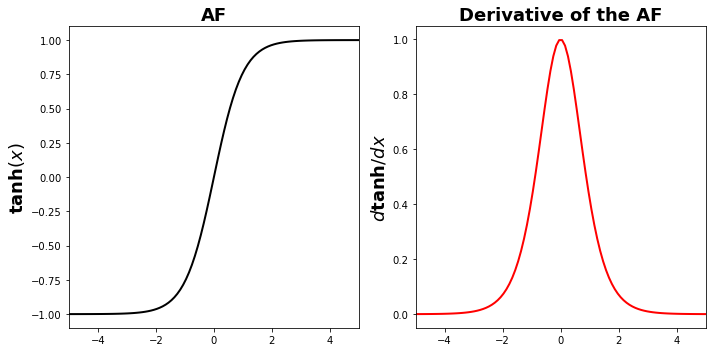

In [31]:
# derivada
x = np.linspace(-5, 5, 100)

def d_tanh(x):
    return 1 - np.tanh(x)**2

d_tanh = np.vectorize(d_tanh)

plot_af(x,
        af=keras.activations.tanh,
        daf=d_tanh,
        af_ylabel=f"tanh$(x)$",
        daf_ylabel=f"$d$tanh$/dx$")

Una primera apreciación importante es que  la $tanh$ tiene un rango que está entre $-1$ y $1$, es decir, puede tomar valores negativos, contrario a las funciones ReLU y sigmoide que solo retornan valores positivos. Esto podría favorecer un entrenamioento más rápido de la red neuronal. Además, al tener una derivada más pronunciada cerca a cero podría acelerar el proceso de entrenamiento siempre  cuando las sumas ponderadas al interior de la neurona permanezcan "pequeños". 

La función tangente hiperbólica presenta una derivada con valores "grandes" cuando está cerca del cero pero tiende a ser nula en los extremos produciendo que el gradiente se desvanezca en esas regiones (más adelante trataremos esto con mayor detalle). Este es un problema para muchas arquitecturas de redes neuronales pues tiende a hacer que la actualización de los pesos se vea frenada cuando la suma ponderada de la neurona es muy grande.

Su uso es recomendado para las capas ocultas de redes neuronales recurrentes (RNN) pues precisamente la característica de que tienda a desvanecer el gradiente ayuda a que este no explote, lo cual puede suceder con relativa facilidad en una RNN al usar otras funciones de activación como ReLU. Por otro lado, no se recomienda su uso en las capas ocultas de redes neuronales profundas pues, aunque tanh puede ser útil en capas ocultas, especialmente en redes neuronales recurrentes, también puede sufrir de saturación en estas redes, lo que puede ralentizar el entrenamiento. 

Tanto la función tanh como la sigmoide se utilizan para problemas de clasificación binarios ubicandolas en la capa de salida de la red. 

In [32]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [33]:
# con tanh de keras
keras.activations.tanh(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.75144671,  0.99963463,  0.96773118,  0.71515836, -0.90989329,
        0.99417464, -0.84779381,  0.99999969,  0.99999998, -0.98128803])>

In [34]:
# con numpy
np.tanh(xp)

array([ 0.75144671,  0.99963463,  0.96773118,  0.71515836, -0.90989329,
        0.99417464, -0.84779381,  0.99999969,  0.99999998, -0.98128803])

Ahora entrenemos un modelo con una función de activación tanh en las capas ocultas. 

In [35]:
# modelo
model_fm_tanh = create_model(name="fashionmn_af_tanh", 
                             shape=train_images[0].shape, 
                             af="tanh",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_tanh.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_tanh.summary()

Model: "fashionmn_af_tanh"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_tanh = model_fm_tanh.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_tanh = history_fm_tanh.history

# medimos el tiempo de ejecución
time_fm_tanh = datetime.datetime.now() - start
print(f"\nTime to run using tanh: {time_fm_tanh}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7721 - loss: 0.6363 - val_accuracy: 0.8459 - val_loss: 0.4189
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8550 - loss: 0.3896 - val_accuracy: 0.8426 - val_loss: 0.4166
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8701 - loss: 0.3531 - val_accuracy: 0.8578 - val_loss: 0.3784
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8781 - loss: 0.3290 - val_accuracy: 0.8658 - val_loss: 0.3586
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8873 - loss: 0.3066 - val_accuracy: 0.8763 - val_loss: 0.3427
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8872 - loss: 0.2970 - val_accuracy: 0.8773 - val_loss: 0.3406
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8942 - loss: 0.2781 - val_accuracy: 0.8835 - val_loss: 0.3274
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9024 - loss: 0.2618 - 

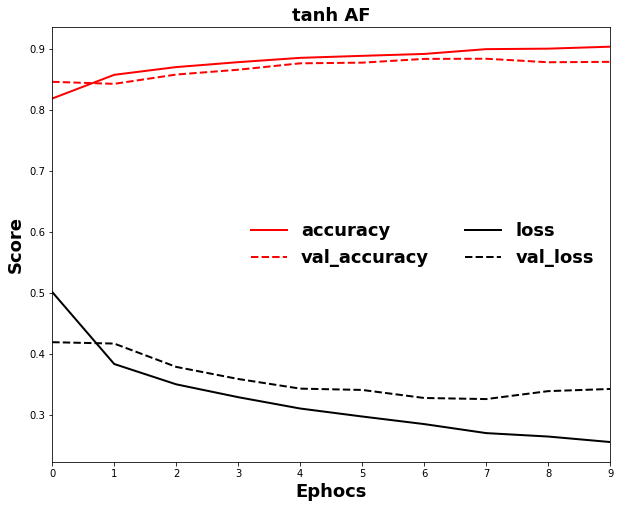

In [37]:
plot_accuracy_loss(history_fm_tanh, name="tanh AF")

In [38]:
# Métricas de testeo
loss_acc_tanh_test = model_fm_tanh.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.3543


In [39]:
# Métricas de entrenamiento
loss_acc_tanh_train = model_fm_tanh.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9066 - loss: 0.2510


### Leaky ReLU

Leaky ReLU es una función de activación que aparece como alternativa para resolver los problemas de ReLU (derivada nula para $x<0$), está definida por:

\begin{eqnarray}
    \text{Leaky ReLU}(x) = \text{max}(\alpha x,x)
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      \alpha & si & x < 0 \\
                                                      1 & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{equation}

donde $\alpha$ es un valor pequeño usualmente 

graficamente tenemos

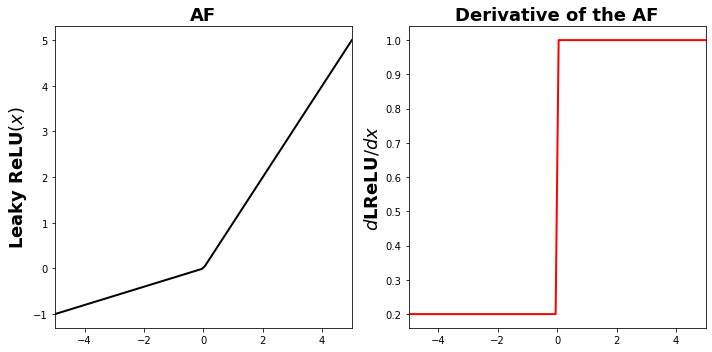

In [40]:
# derivada
x = np.linspace(-5, 5, 100)

alpha = 0.2
def d_lrelu(x, alpha=alpha):
    if x<0:
        return alpha
    return 1

d_lrelu = np.vectorize(d_lrelu)

plot_af(x,
        af=keras.activations.leaky_relu,
        daf=d_lrelu,
        af_ylabel=f"Leaky ReLU$(x)$",
        daf_ylabel=f"$d$LReLU$/dx$", **{"negative_slope":alpha})

En comparación con ReLU, Al permitir un pequeño gradiente para las entradas negativas, Leaky ReLU evita el problema de que algunas neuronas se vuelvan "inactivas", además Leaky ReLU puede ayudar a reducir la probabilidad de que ocurra el desvanecimiento del gradiente en comparación con ReLU, especialmente en redes neuronales más profundas.

Leaky ReLU sigue siendo tema de investigación al igual que muchas otras funciones de activación, por esto no siempre se usa para las capas ocultas y sigue siendo más frecuente el uso de ReLU pero quizá esto cambie conforme avancen los estudios sobre las funciones de activación. 

Una ventaja que tienen tanto ReLU como Leaky ReLU sobre funciones de activación como la logística o tanh que están definidas usando exponenciales y divisiones, es que no son tan costosas computacionalmente hablando, por lo que su uso sigue siendo preferido en las capas ocultas de muhas redes.

In [41]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [42]:
keras.activations.leaky_relu(xp, negative_slope=alpha)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -0.30538081,
        2.91788226, -0.24965116,  7.83546002,  9.27325521, -0.46623393])>

In [43]:
# modelo
model_fm_lrelu = create_model(name="fashionmn_af_lrelu", 
                             shape=train_images[0].shape, 
                             af="leaky_relu",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_lrelu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_lrelu.summary()

Model: "fashionmn_af_lrelu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_lrelu = model_fm_lrelu.fit(train_images,
                                      train_labels,
                                      validation_split=0.2,
                                      epochs=10)

history_fm_lrelu = history_fm_lrelu.history
# medimos el tiempo de ejecución
time_fm_lrelu = datetime.datetime.now() - start
print(f"\nTime to run using leaky relu: {time_fm_lrelu}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7534 - loss: 0.6893 - val_accuracy: 0.8483 - val_loss: 0.4146
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8511 - loss: 0.4065 - val_accuracy: 0.8714 - val_loss: 0.3605
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8678 - loss: 0.3551 - val_accuracy: 0.8661 - val_loss: 0.3742
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8799 - loss: 0.3258 - val_accuracy: 0.8748 - val_loss: 0.3522
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8836 - loss: 0.3147 - val_accuracy: 0.8703 - val_loss: 0.3585
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8883 - loss: 0.2963 - val_accuracy: 0.8673 - val_loss: 0.3714
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8940 - loss: 0.2840 - val_accuracy: 0.8704 - val_loss: 0.3448
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8979 - loss: 0.2724 - 

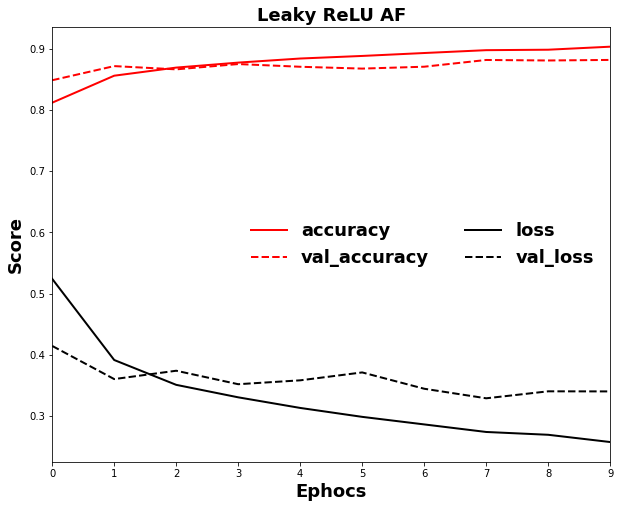

In [45]:
plot_accuracy_loss(history_fm_lrelu, name="Leaky ReLU AF")

In [46]:
# Métricas de testeo
loss_acc_lrelu_test = model_fm_lrelu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8725 - loss: 0.3585


In [47]:
# Métricas de entrenamiento
loss_acc_lrelu_train = model_fm_lrelu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9073 - loss: 0.2477


### ELU
El estudio de las funciones de activación es un campo bastante activo, entre las últimas propuestas tenemos ELU, Exponential Linear Units, definida como:

\begin{eqnarray}
    \text{ELU}(x) = \left\{ \begin{array}{lcc} 
                                                      \alpha(e^x-1) & si & x < 0 \\
                                                      x  & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      \alpha e^x & si & x < 0 \\
                                                      1 & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{equation}

donde $\alpha$ es un parámetro que se suele establecer igual $1$.

graficamente tenemos

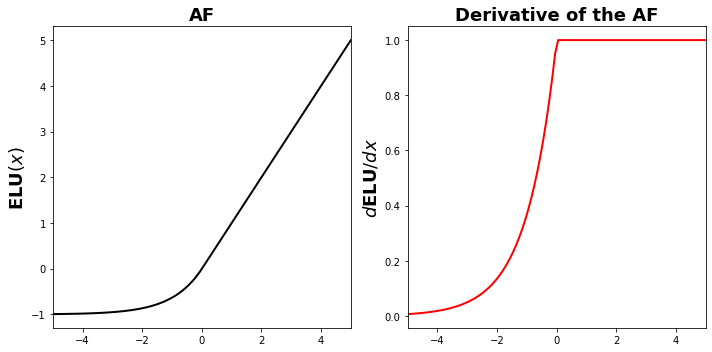

In [48]:
# derivada
x = np.linspace(-5, 5, 100)

alpha = 1
def d_elu(x, alpha=alpha):
    if x<0:
        return alpha*np.exp(x)
    return 1

d_elu = np.vectorize(d_elu)

plot_af(x,
        af=keras.activations.elu,
        daf=d_elu,
        af_ylabel=f"ELU$(x)$",
        daf_ylabel=f"$d$ELU$/dx$", **{"alpha":alpha})

Al igual que Leaky ReLU, ELU viene a solventar algunos de los problemas de ReLU como lo son las neuronas muertas. A diferencia de Leaky ReLu, ELU es más suave por lo que su derivadda  también tiende a serlo permitiendo un mejor entrenamiento en capas ocultas. Aún así, ELU es computacionalmente más costosa por la presencia del exponencial. 

In [49]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [50]:
keras.activations.elu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -0.7827929 ,
        2.91788226, -0.71299504,  7.83546002,  9.27325521, -0.90281799])>

In [51]:
# modelo
model_fm_elu = create_model(name="fashionmn_af_elu", 
                            shape=train_images[0].shape, 
                            af="elu",
                            output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_elu.compile(optimizer=opt,
                     loss=loss,
                     metrics=["accuracy"])

model_fm_elu.summary()

Model: "fashionmn_af_elu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_elu = model_fm_elu.fit(train_images,
                                  train_labels,
                                  validation_split=0.2,
                                  epochs=10)

history_fm_elu = history_fm_elu.history

# medimos el tiempo de ejecución
time_fm_elu = datetime.datetime.now() - start
print(f"\nTime to run using elu: {time_fm_elu}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7699 - loss: 0.6324 - val_accuracy: 0.8561 - val_loss: 0.4008
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8543 - loss: 0.3936 - val_accuracy: 0.8618 - val_loss: 0.3745
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8698 - loss: 0.3539 - val_accuracy: 0.8691 - val_loss: 0.3585
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8779 - loss: 0.3244 - val_accuracy: 0.8582 - val_loss: 0.3832
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8870 - loss: 0.3024 - val_accuracy: 0.8755 - val_loss: 0.3524
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8905 - loss: 0.2945 - val_accuracy: 0.8827 - val_loss: 0.3255
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9004 - loss: 0.2663 - val_accuracy: 0.8770 - val_loss: 0.3372
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9008 - loss: 0.2644 - 

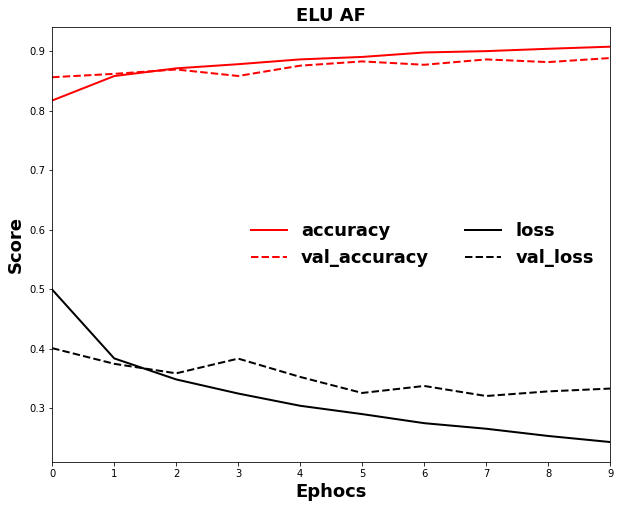

In [53]:
plot_accuracy_loss(history_fm_elu, name="ELU AF")

In [54]:
# Métricas de testeo
loss_acc_elu_test = model_fm_elu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8807 - loss: 0.3587


In [55]:
# Métricas de entrenamiento
loss_acc_elu_train = model_fm_elu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9158 - loss: 0.2218


### GELU
Finalmente vemos la función de activación [GELU](https://arxiv.org/pdf/1606.08415), esá definida como:

\begin{eqnarray}
    \text{ELU}(x) = \frac{x}{2}\left[ 1 + \text{erf}(x/\sqrt{2}) \right]
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ELU}}{dx} = \frac{1}{2}\left[ 1 + \text{erf}(x/\sqrt{2}) \right] + \frac{x}{\sqrt{2\pi}}e^{-x^2/2}
\end{equation}

graficamente tenemos

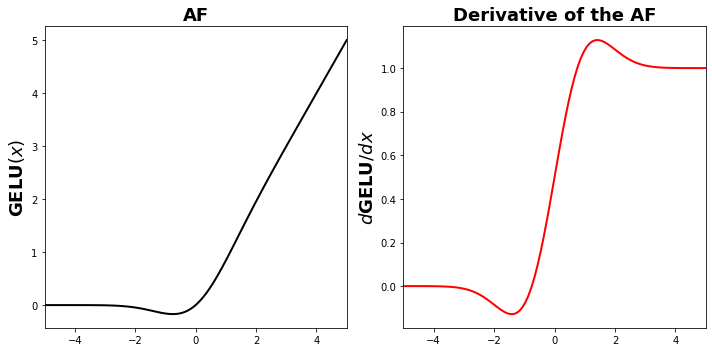

In [56]:
# derivada
from scipy.special import erf

x = np.linspace(-5, 5, 100)

def d_gelu(x):
    return 0.5*(1+erf(x/np.sqrt(2))) + x*np.exp(-x**2/2)/np.sqrt(2*np.pi)

d_gelu = np.vectorize(d_gelu)

plot_af(x,
        af=keras.activations.gelu,
        daf=d_gelu,
        af_ylabel=f"GELU$(x)$",
        daf_ylabel=f"$d$GELU$/dx$")

Una característica que claramente distingue a GELU de las otras funciones de activación es que no es monótona. Al no serlo, GELU puede capturar relaciones no lineales más complejas entre las características de entrada y la salida de la red neuronal. Esto significa que puede adaptarse mejor a la complejidad de los datos, lo que potencialmente puede llevar a un mejor rendimiento del modelo.
Además, su falta de monotonía permite que la función de activación capture relaciones no lineales más complejas en los datos, lo que lleva a un mejor rendimiento del modelo y una mejor capacidad para modelar la variabilidad de los datos del mundo real.

UNa gran desventaja de esta función de activación es que es muy costosa computacionalmente devido a la presencia de la función de error que es bastante compleja de calcular. 

In [57]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [58]:
keras.activations.gelu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.81570751,  4.3037512 ,  2.01431306,  0.73188094, -0.09679417,
        2.9127407 , -0.13227604,  7.83546002,  9.27325521, -0.02301379])>

In [59]:
# modelo
model_fm_gelu = create_model(name="fashionmn_af_gelu", 
                             shape=train_images[0].shape, 
                             af="gelu",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_gelu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_gelu.summary()

Model: "fashionmn_af_gelu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_gelu = model_fm_gelu.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_gelu = history_fm_gelu.history

# medimos el tiempo de ejecución
time_fm_gelu = datetime.datetime.now() - start
print(f"\nTime to run using gelu: {time_fm_gelu}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7480 - loss: 0.6860 - val_accuracy: 0.8353 - val_loss: 0.4322
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8584 - loss: 0.3798 - val_accuracy: 0.8601 - val_loss: 0.3877
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8744 - loss: 0.3352 - val_accuracy: 0.8746 - val_loss: 0.3428
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8853 - loss: 0.3107 - val_accuracy: 0.8827 - val_loss: 0.3312
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8921 - loss: 0.2873 - val_accuracy: 0.8747 - val_loss: 0.3481
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8967 - loss: 0.2686 - val_accuracy: 0.8842 - val_loss: 0.3257
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9021 - loss: 0.2595 - val_accuracy: 0.8808 - val_loss: 0.3344
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9070 - loss: 0.2498 - 

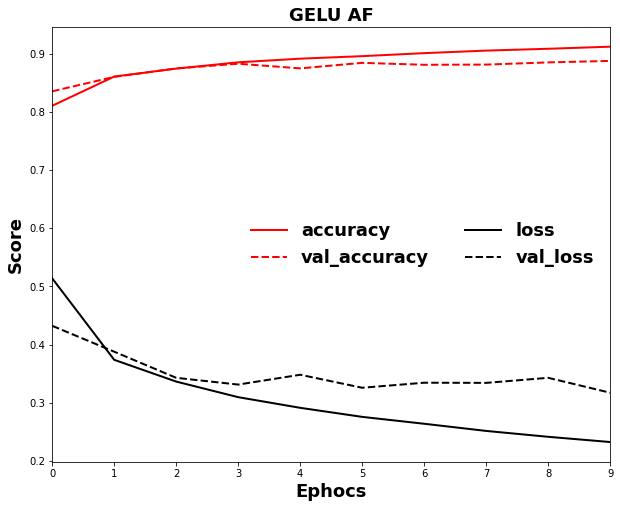

In [61]:
plot_accuracy_loss(history_fm_gelu, name="GELU AF")

In [62]:
# Métricas de testeo
loss_acc_gelu_test = model_fm_gelu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8855 - loss: 0.3312


In [63]:
# Métricas de entrenamiento
loss_acc_gelu_train = model_fm_gelu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9250 - loss: 0.1964


### Comparación entre las funciones de activación
Ahora analicemos un poco los resultados obtenidos con cada función de activación.

In [64]:
af_info = {"linear":     [time_fm_linear.total_seconds(), *loss_acc_linear_train, *loss_acc_linear_test],
           "sigmoid":    [time_fm_sig.total_seconds(),    *loss_acc_sig_train,    *loss_acc_sig_test],
           "tanh":       [time_fm_tanh.total_seconds(),   *loss_acc_tanh_train,   *loss_acc_tanh_test],
           "ReLU":       [time_fm_relu.total_seconds(),   *loss_acc_relu_train,   *loss_acc_relu_test],
           "Leaky ReLU": [time_fm_lrelu.total_seconds(),  *loss_acc_lrelu_train,  *loss_acc_lrelu_test],
           "ELU":        [time_fm_elu.total_seconds(),    *loss_acc_elu_train,    *loss_acc_elu_test],
           "GELU":       [time_fm_gelu.total_seconds(),   *loss_acc_gelu_train,   *loss_acc_gelu_test]
           }

af_info = pd.DataFrame(af_info, index=["time", "loss_train", "accuracy_train", "loss_test", "accuracy_test" ]).T
af_info = af_info.sort_values(by="time", ascending=True)
af_info

,time,loss_train,accuracy_train,loss_test,accuracy_test
Leaky ReLU,47.358383,0.266077,0.902183,0.364555,0.8737
ReLU,50.199215,0.265108,0.904117,0.371390,0.8769
ELU,50.330339,0.243978,0.910317,0.365771,0.8795
GELU,51.710238,0.219039,0.918100,0.330561,0.8824
linear,57.161298,0.413245,0.857233,0.474831,0.8335
tanh,68.566161,0.267465,0.902133,0.362125,0.8725
sigmoid,73.346506,0.303796,0.889717,0.396653,0.8591


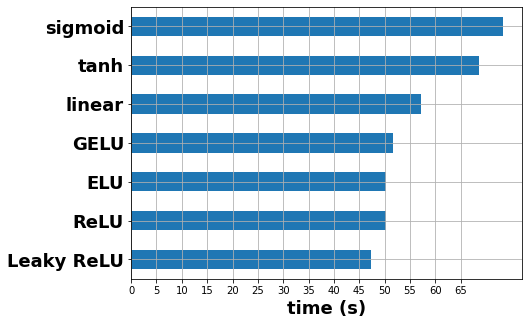

In [65]:
fig, ax = plt.subplots(figsize=(7,5))
af_info.time.plot(kind="barh", ax=ax)

ax.set_yticklabels(af_info.index, rotation=0, **font)
ax.set_xticks(ticks=np.arange(0,66,5))
ax.set_xlabel("time (s)", **font)
ax.grid()
plt.show()

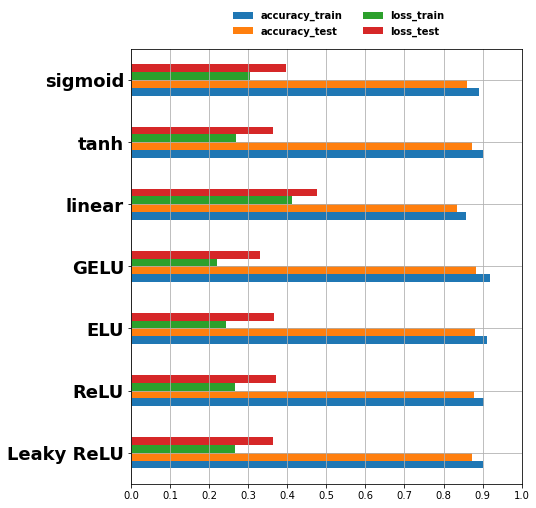

In [66]:
fig, ax = plt.subplots(figsize=(7,8))
af_info.loc[:, ["accuracy_train",
                "accuracy_test",
                "loss_train",
                "loss_test" ]].plot(kind="barh", ax=ax)

ax.set_yticklabels(af_info.index, rotation=0, **font)
ax.set_xticks(ticks=np.linspace(0,1,11))
ax.legend(loc=(0.25, 1.02), ncol=2, prop=font_leg, frameon=False)
ax.grid()
plt.show()

¿Cómo se comparan las funciones de activación entre ellas?

### Definiendo nuestra propia función de activación

En caso que precisemos crear nuestras propias funciones de activación lo podemos hacer de diferentes maneras:
* Definiendo la función de activación
* Igual que el método anterior pero utilizando el decorador <code>@tf.function</code>.
* Usando una función/capa lambda.

También es posible escribir la función de activación como una clase que hereda de <code>Layer</code> en casos más complejos, por ejemplo, si queremos que nuestra función de activación sea una capa con algunos parámetros que también queremos optimizar en el proceso de entrenamiento. En este curso no veremos este método. 

La función de activación que se defina, con cualquiera de los métodos, debe recibir un tensor y retornar otro con iguales dimensiones. Una manera sencilla de hacer esto es por medio del módulo <code>keras.backend</code>. Este contiene gran variedad de funciones matemáticas que nos podrían ayudar a lograr nuestro objetivo. 

#### Definiendo la función de activación.

In [67]:
def custom_af_1(x):
    return tf.keras.backend.sin(x)

model_custom_af_1 = create_model(name="custom_af_1",
                                 shape=train_images[0].shape, 
                                 af=custom_af_1)

opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_custom_af_1.compile(optimizer=opt,
                          loss=loss,
                          metrics=["accuracy"])

model_custom_af_1.summary()

Model: "custom_af_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
"""
# Entrenamiento 
history_custom_af_1 = model_custom_af_1.fit(train_images,
                                            train_labels,
                                            validation_split=0.2,
                                            epochs=10)

history_custom_af_1 = history_custom_af_1.history
"""
print()

#### Utilizando el decorador <code>@tf.function</code>

In [69]:
@tf.function
def custom_af_2(x):
    return tf.sin(x)

model_custom_af_2 = create_model(name="custom_af_2",
                                 shape=train_images[0].shape, 
                                 af=custom_af_2)

opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_custom_af_2.compile(optimizer=opt,
                          loss=loss,
                          metrics=["accuracy"])

model_custom_af_2.summary()

Model: "custom_af_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
"""
# Entrenamiento 
history_custom_af_2 = model_custom_af_2.fit(train_images,
                                            train_labels,
                                            validation_split=0.2,
                                            epochs=10)

history_custom_af_2 = history_custom_af_2.history
"""
print()

Como se puede ver, la diferencia entre estos dos métodos es sólo el uso del decorador <code>@tf.function</code>.  Usarlo puede mejorar el rendimiento y la eficiencia de la función de activación personalizada, ya que se compila en TensorFlow antes de la ejecución, esto puede ser especialmente beneficioso en modelos con grandes cantidades de datos y/o capas. Esta es la forma sugerida para definir nuevas funciones de activación.

#### Usando una función lambda

In [71]:
custum_af_3 = lambda x: keras.backend.sin(x)

model_custum_af_3 = create_model(name="custum_af_3",
                                 shape=train_images[0].shape, 
                                 af=custum_af_3)

opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_custum_af_3.compile(optimizer=opt,
                          loss=loss,
                          metrics=["accuracy"])

model_custum_af_3.summary()

Model: "custum_af_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
"""
# Entrenamiento 
history_custum_af_3 = model_custum_af_3.fit(train_images,
                                            train_labels,
                                            validation_split=0.2,
                                            epochs=10)

history_custum_af_3 = history_custum_af_3.history
"""
print()

## Funciones de perdida

## Optimizadores

## Algoritmo de Backpropagation